In [1]:
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle


# Make plots with the experiments listed in order of ACC

In [2]:
def unique_channels(file_list):
    all_channels = []
    experiment_names = []
    for file in file_list:
        # break
        #First read the file and get all of the header information
        op = pd.read_csv(file,header=[0])
        col_names = op.columns
        [all_channels.append(i) for i in col_names[1:] if i not in all_channels]
        experiment_names.append(file.split('/')[-1].split('.')[0])
        
    return(all_channels,experiment_names)

def create_pd_dataset(blank_df, file_list):
    for file in file_list:
        # break
        col_name = file.split('/')[-1].split('.')[0]
        #First read the file and get all of the header information
        op = pd.read_csv(file,header=[0])
        col_names = op.columns[1:]
        #Now replace the data in the blank_df
        for i in col_names:
            # break
            blank_df.loc[i,col_name] = op[i][0]
            
    return(blank_df)

def load_ACC_files_make_mean(lead,permuation_dir):
    # Open the file in binary read mode ('rb') and use pickle.load() to load the dictionary
    ACC_path = f'{permuation_dir}/ACC_vals.pkl'
    with open(ACC_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    
    #Take the mean of each experiment
    out_mean = {}
    for ex in list(loaded_dict.keys()):
        # break
        #Get name of each EX
        sp = ex.split('_')
        name = f'{sp[1]}_{sp[3]}'
        out_mean[name] = loaded_dict[ex]
    
    #rename baseline reforecast
    # Specify the key to be renamed
    old_key = 'MEM_RZSM'
    new_key = 'Baseline_fcst'

    # Create a new key-value pair with the desired key for the baseline GEFSv12 reforecast
    out_mean[new_key] = out_mean.pop(old_key)
    out_mean
    
    return(out_mean)


def channel_list_recreate(channels):
    #re-order channels
    rzsm_ = sorted([i for i in channels if 'RZSM' in i])
    element_to_move = 'RZSM_obs_lag-7'
    desired_position = 1  # 3rd position (0-based index)

    rzsm_.remove(element_to_move)  # Remove the element from its current position
    rzsm_.insert(desired_position, element_to_move)
    
    other_channels = [i for i in channels if 'RZSM' not in i]
    
    return(rzsm_+other_channels)

In [4]:
'''We are going to take the average of certain columns and replace them in the dataframe'''
def average_variables(sorted_columns):
    
    var_list = ['diff_temp_obs','tmax_obs','spfh_obs','pwat_obs','z200_obs']
    var_list_name = [f'{i}_lag_Wk_1-3' for i in var_list]
    
    df  =pd.DataFrame(columns = sorted_columns.columns, index = var_list_name)
    for var in var_list:
        filtered_rows = sorted_columns[sorted_columns.index.str.contains(var)]
        # Calculate the mean for each column separately
        mean_of_diff_temp_rows = filtered_rows.mean(axis=0)
        df.loc[f'{var}_lag_Wk_1-3',:] = mean_of_diff_temp_rows[:]
    
        '''Now delete the old ones'''
    
    for var in var_list:
       sorted_columns = sorted_columns[~sorted_columns.index.str.contains(var)]

    '''Now add back to the dataset'''
    sorted_columns = pd.concat([sorted_columns,df])

    

    '''Now average RZSM'''
    r1 = ['RZSM_obs_lag-21','RZSM_obs_lag-28','RZSM_obs_lag-35']
    r2 = ['RZSM_obs_lag-42','RZSM_obs_lag-49','RZSM_obs_lag-56']
    r3 = ['RZSM_obs_lag-63','RZSM_obs_lag-70','RZSM_obs_lag-77']
    
    sorted_columns1 = sorted_columns[sorted_columns.index.str.contains(r1[0]) | sorted_columns.index.str.contains(r1[1]) | sorted_columns.index.str.contains(r1[2])].mean(axis=0)
    sorted_columns2 = sorted_columns[sorted_columns.index.str.contains(r2[0]) | sorted_columns.index.str.contains(r2[1]) | sorted_columns.index.str.contains(r2[2])].mean(axis=0)
    sorted_columns3 = sorted_columns[sorted_columns.index.str.contains(r3[0]) | sorted_columns.index.str.contains(r3[1]) | sorted_columns.index.str.contains(r3[2])].mean(axis=0)
    
    
    for v in [r1,r2,r3]:
        for var in v:
           sorted_columns = sorted_columns[~sorted_columns.index.str.contains(var)]

    '''Now add back to the dataset'''
    sorted_columns.loc['RZSM_obs_lag_Wk_4-6',:] = sorted_columns1
    sorted_columns.loc['RZSM_obs_lag_Wk_7-9',:] = sorted_columns2
    sorted_columns.loc['RZSM_obs_lag_Wk_10-12',:] = sorted_columns3

    sorted(sorted_columns)
    return(sorted_columns)


In [5]:
# def loop_through_experiment_type_and_average(lead):
#     '''
#     permuation_dir = f'Outputs/permutation_tests/Wk{lead}'
#     file_list = glob(f'{permuation_dir}/*RZSM.csv')
    
#     #Make list of channel names and experiments
#     channels,experiment_names = unique_channels(file_list)

/glade/derecho/scratch/klesinger/tmp/ipykernel_739/1042201976.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_columns = pd.concat([sorted_columns,df])


X: 480
Y: 480
C: 480


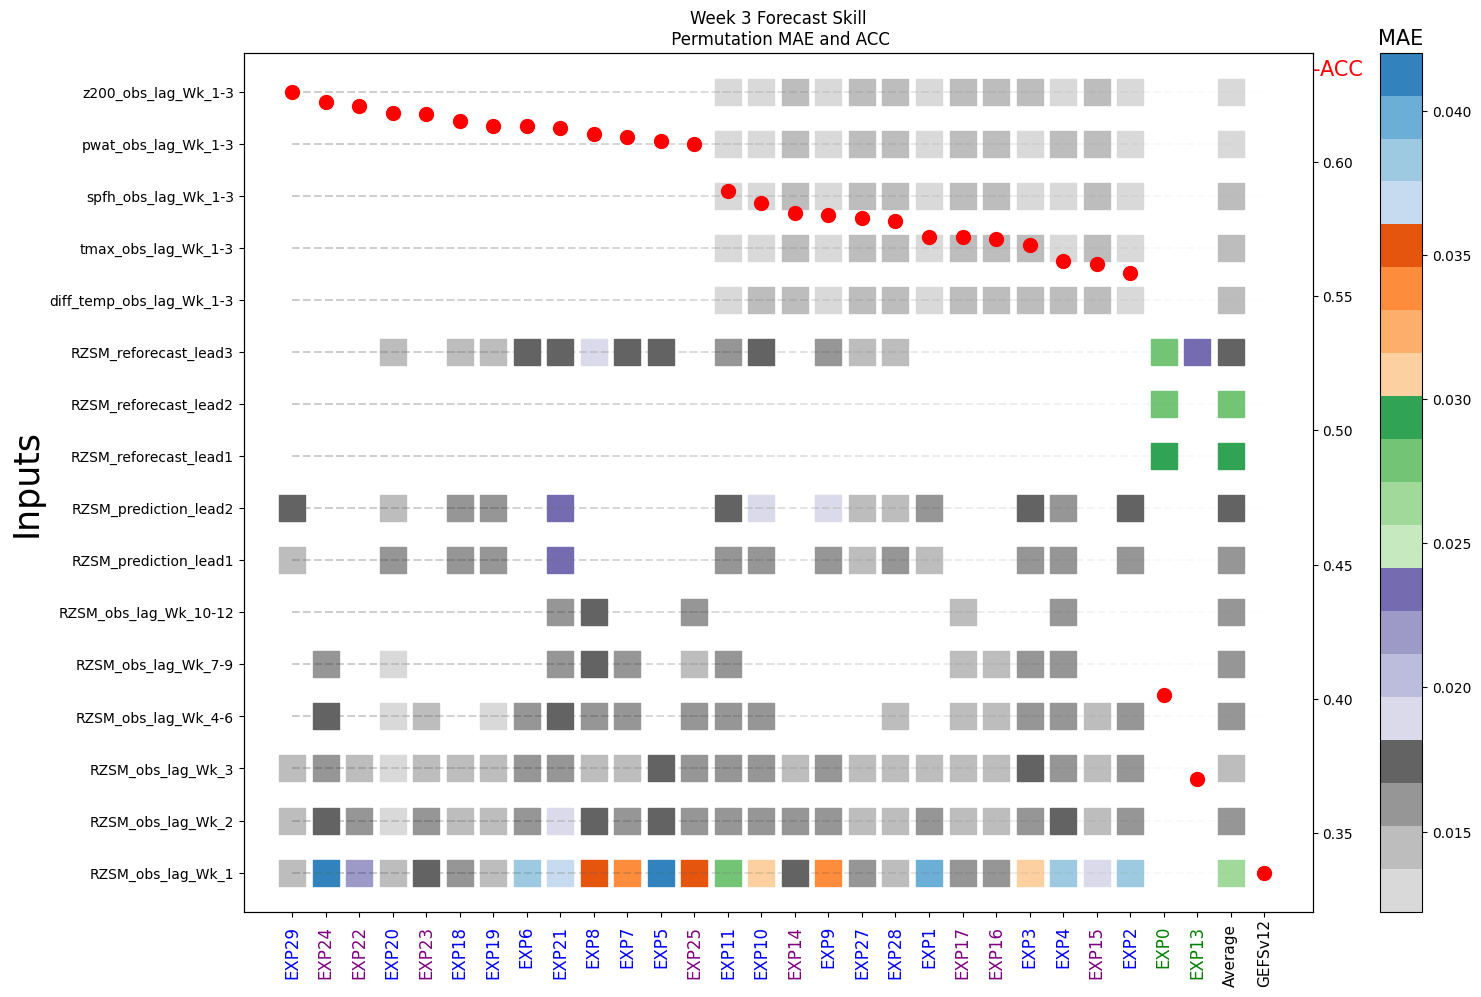

In [7]:


def plot_lead_include_ACC_value_also_ALL_CHANNELS(lead):
    assert lead == 3, 'For this particular plot, it is only good for lead == 3'
    global permuation_dir
    permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'
    
    file_list = glob(f'{permuation_dir}/*RZSM.csv')

    #Make list of channel names and experiments
    channels,experiment_names = unique_channels(file_list)
    experiment_names = [i for i in experiment_names if 'EX26' not in i]
    
    channels =  channel_list_recreate(channels)
    
    mean_ACC = load_ACC_files_make_mean(lead,permuation_dir)
    del mean_ACC['EX26_RZSM']
    
    channels = channels+['ACC']
    
    # Create a blank DataFrame with the specified dimensions
    blank_df = pd.DataFrame(index=channels, columns=experiment_names)

    #Set up within a csv file for plotting
    filled_df = create_pd_dataset(blank_df, file_list)
    filled_df = average_variables(filled_df)

    filled_df['Baseline_fcst'] = np.nan
    
    filled_df['Average'] = filled_df.mean(axis=1)

    filled_df= filled_df.drop('RZSM_prediction_lead0')
    filled_df= filled_df.drop('RZSM_ref_lead0')
    del filled_df['EX26_RZSM']
    del filled_df['EX12_RZSM']
    
    #Now add ACC values
    for k,v in (mean_ACC.items()):
        # break
        filled_df.loc['ACC',k] = v

    # Remove the row you want to move
    moved_row = filled_df.loc['ACC']
    filled_df = filled_df.drop(index='ACC')
    
    # Concatenate the DataFrame with the row moved to the bottom
    filled_df = pd.concat([filled_df, moved_row.to_frame().T])
    #Now sort by ACC value
    # Row index for sorting
    row_index_to_sort_by = -1

    # Get the column indices sorted based on the values in the specified row in descending order
    sorted_column_indices = np.argsort(filled_df.iloc[row_index_to_sort_by].values)[::-1]

    # Select columns based on the sorted indices
    sorted_columns = filled_df.iloc[:, sorted_column_indices]
    
    # Move the first column to the end
    columns = list(sorted_columns.columns)
    columns.append(columns.pop(0))
    sorted_columns = sorted_columns[columns]
    
    # #ACC col, row
    acc_row = sorted_columns.iloc[-1,:]
    # #Delete ACC row because it is already sorted
    sorted_columns = sorted_columns.iloc[:-1,:]

    #re-order to this order for rows
    new_ytick_labels = ['RZSM_obs_lag-1', 'RZSM_obs_lag-7', 'RZSM_obs_lag-14','RZSM_obs_lag_Wk_4-6', 'RZSM_obs_lag_Wk_7-9', 'RZSM_obs_lag_Wk_10-12', 'RZSM_prediction_lead1', 'RZSM_prediction_lead2', 'RZSM_ref_lead1', 'RZSM_ref_lead2', 'RZSM_ref_lead3', 'diff_temp_obs_lag_Wk_1-3', 'tmax_obs_lag_Wk_1-3', 'spfh_obs_lag_Wk_1-3', 'pwat_obs_lag_Wk_1-3', 'z200_obs_lag_Wk_1-3',]

    sorted_columns = sorted_columns.reindex(new_ytick_labels)

    #re-order columns
    experiment_names= [i for i in experiment_names if 'EX26_RZSM' not in i]
    experiment_names= [i for i in experiment_names if 'EX12_RZSM' not in i]
    len_experiment = len(experiment_names)
    # new_columns = [f'EX{i}_RZSM' for i in range(0,len_experiment)]
    # new_columns.append('Average')

    
    column_to_move = sorted_columns.pop('Average')
    sorted_columns = pd.concat([sorted_columns, column_to_move], axis=1)
    sorted_columns.rename(columns={'Baseline_fcst': 'GEFSv12'}, inplace=True)
    column_to_move = sorted_columns.pop('GEFSv12')
    sorted_columns = pd.concat([sorted_columns, column_to_move], axis=1)
    
    col_names = sorted_columns.columns

    def return_color(i):
        # Experiment info
        green = ['EX0','EX13'] # bias-correction
        purple = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] # obs.-driven
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28'] # hybrid

        if ('Average' in i) or ('GEFSv12' in i):
            return('black')
        for g in green:
            if g in i:
                return('green')
        for p in purple:
            if p in i:
                return('purple')
        for b in blue:
            if b in i:
                return('blue')

    
    '''Color code the x axis labels'''
    # We don't have an experiment 12
    #For plotting
    tick_labels = [f"{i.split('_')[0]}" for i in col_names]
    color1 = {k:return_color(k) for k in tick_labels}

    sorted_columns.rename(index = {'RZSM_obs_lag-1':'RZSM_obs_lag_Wk_1','RZSM_obs_lag-7':'RZSM_obs_lag_Wk_2','RZSM_obs_lag-14':'RZSM_obs_lag_Wk_3',})
    
    # Flatten the DataFrame for scatter plot
    fig, ax1 = plt.subplots(figsize=(16, 10))
    x_values = np.tile(sorted_columns.columns, len(sorted_columns.index.tolist()))
    y_values = np.repeat(sorted_columns.index.tolist(), len(sorted_columns.columns))
    colors = sorted_columns.values.flatten()

    '''min max scale'''
    # min_, max_ = np.nanmin(colors), np.nanmax(colors)
    # colors = (colors - min_)/(max_-min_)
        
    print(f'X: {len(x_values)}')
    print(f'Y: {len(y_values)}')
    print(f'C: {len(colors)}')
          
    # Plot the scatter plot
    scatter=ax1.scatter(x=x_values, y=y_values, c=colors, cmap='tab20c_r', marker='s',s=350)
    # ax1.set_xticklabels(sorted_columns.columns, rotation=45, ha='right')

    # ax1.set_xlabel('Experiments',fontsize=25)
    ax1.set_ylabel('Inputs',fontsize=25)

    
    # Draw lines connecting each point to the x-axis
    for i, (xi, yi) in enumerate(zip(x_values, y_values)):
        plt.hlines(yi, 0, xi, linestyle='dashed', color='gray', alpha=0.01)

    ax1.set_xticklabels('', rotation=45, ha='center')
    cat_drop = 1.39
    for i, category in enumerate(tick_labels):
        # break
        if category in ['Average','GEFSv12']:
            plt.text(i , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=90, ha='center',fontsize=11)
        else:
            if len(category) == 3:
                ex_drop = 1.0
            else:
                ex_drop = 1.2
            plt.text(i , plt.ylim()[0] - ex_drop, f'{category[0:2]}P{category[2:]}', color=color1.get(category, 'black'), rotation=90, ha='center',fontsize=12)

    new_ytick_labels = ['RZSM_obs_lag_Wk_1', 'RZSM_obs_lag_Wk_2', 'RZSM_obs_lag_Wk_3','RZSM_obs_lag_Wk_4-6', 'RZSM_obs_lag_Wk_7-9', 'RZSM_obs_lag_Wk_10-12', 'RZSM_prediction_lead1', 'RZSM_prediction_lead2', 'RZSM_reforecast_lead1', 'RZSM_reforecast_lead2', 'RZSM_reforecast_lead3', 'diff_temp_obs_lag_Wk_1-3', 'tmax_obs_lag_Wk_1-3', 'spfh_obs_lag_Wk_1-3', 'pwat_obs_lag_Wk_1-3', 'z200_obs_lag_Wk_1-3',]
    
    ax1.set_yticks(np.arange(len(new_ytick_labels)))
    ax1.set_yticklabels(new_ytick_labels)
    
    cbar = plt.colorbar(scatter, ax=ax1)
    # cbar.set_label(label='MAE',size=15, labelpad=20)
    cbar.ax.set_title('MAE',fontsize=15)
    ax1.text(x_ACC, y_ACC, f'-ACC', va='center', ha='left', rotation='horizontal', fontsize=15, transform=ax1.transAxes,color='red')
    # cbar.ax.tick_params(labelsize=15)
    
    # Create a twin Axes for the second scatter plot
    ax2 = ax1.twinx()
    '''change the labels'''
    second_last = acc_row.iloc[-2] # Extract the second-from-last item

    acc_row = acc_row.drop(acc_row.index[-2]) # Drop the second-from-last item
    acc_row = pd.concat([acc_row, pd.Series([second_last], name = 'GEFSv12')]) # Append the second-from-last item to the end
    
    # del acc_row['EX12_RZSM']
    scatter_2 = ax2.scatter(col_names, acc_row, marker='o', label='ACC', color='red', s=100)
    ax2.tick_params(left = False)
    ax2.set_title(f'Week {lead} Forecast Skill\n Permutation MAE and ACC')

#     ax.set_xticklabels(sorted_columns.columns, rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.savefig(f'Outputs/permutation_tests/Wk_{lead}_scatterplots_with_ACC_values.png')
    
    # plt.show()
    
    
    
    return(0)

# for lead in [0,1,2,3,4]:
#     plot_lead_include_ACC_value_also_ALL_CHANNELS(lead=lead)

global x_ACC, y_ACC

x_ACC = 1.000
y_ACC = 0.98

for lead in [3]:
    plot_lead_include_ACC_value_also_ALL_CHANNELS(lead=lead)



In [ ]:

def plot_lead_sorted_ACC_but_not_value(lead):
    permuation_dir = f'Outputs/permutation_tests/Wk{lead}'

    file_list = glob(f'{permuation_dir}/*RZSM.csv')
    
    #Make list of channel names and experiments
    channels,experiment_names = unique_channels(file_list)
    
    channels =  channel_list_recreate(channels)
    
    mean_ACC = load_ACC_files_make_mean(lead,permuation_dir)
    
    #Don't add the baseline reforecast in this plot
    del mean_ACC['Baseline_fcst']
    
    channels = channels+['ACC']
    
    # Create a blank DataFrame with the specified dimensions
    blank_df = pd.DataFrame(index=channels, columns=experiment_names)

    #Set up within a csv file for plotting
    filled_df = create_pd_dataset(blank_df, file_list)
    
    filled_df['Average'] = filled_df.mean(axis=1)
    
    #Now add ACC values
    for k,v in (mean_ACC.items()):
        # break
        filled_df.loc['ACC',k] = v
    
    #Now sort by ACC value
    # Row index for sorting
    row_index_to_sort_by = -1

    # Get the column indices sorted based on the values in the specified row in descending order
    sorted_column_indices = np.argsort(filled_df.iloc[row_index_to_sort_by].values)[::-1]

    # Select columns based on the sorted indices
    sorted_columns = filled_df.iloc[:, sorted_column_indices]
    
    # Move the first column to the end
    columns = list(sorted_columns.columns)
    columns.append(columns.pop(0))
    sorted_columns = sorted_columns[columns]
    
    #Delete ACC row because it is already sorted
    sorted_columns = sorted_columns.iloc[:-1,:]

    #Get the number of np.nan in each column
    # num_nan_columns = filled_df.isna().sum(axis=0)
    
    # Sort columns based on the number of NaN values in descending order
    # sorted_columns = num_nan_columns.sort_values(ascending=True).index
    
    # Reorder columns based on sorted order
    #re-order columns
    len_experiment = len(experiment_names)
    # new_columns = [f'EX{i}_RZSM' for i in range(0,len_experiment)]
    # new_columns.append('Average')
    
    col_names = sorted_columns.columns
    
    # Flatten the DataFrame for scatter plot
    fig, ax = plt.subplots(figsize=(16, 10))
    x_values = np.tile(sorted_columns.columns, len(channels[:-1]))
    y_values = np.repeat(channels[:-1], len(sorted_columns.columns))
    colors = sorted_columns.values.flatten()
    print(f'X: {len(x_values)}')
    print(f'Y: {len(y_values)}')
    print(f'C: {len(colors)}')
          
    # Plot the scatter plot
    scatter = ax.scatter(x=x_values, y=y_values, c=colors, cmap='tab20c_r', marker='s',s=350)
    
    # Draw lines connecting each point to the x-axis
    for i, (xi, yi) in enumerate(zip(x_values, y_values)):
        plt.hlines(yi, 0, xi, linestyle='dashed', color='gray', alpha=0.01)
        
    # Customize the plot
    ax.set_xlabel('Experiment Names\n <<<------------------------- Highest ACC     Lowest ACC------------------------->>>')
    ax.set_ylabel('Predictor Names')
    ax.set_title('Permutation tests and ACC sorted values')

    # Add a colorbar
    ticks = np.linspace(np.nanmin(colors), np.nanmax(colors), num=20)
    cbar = plt.colorbar(scatter, ax=ax, label='MAE',ticks=ticks)
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(sorted_columns.columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'Outputs/permutation_tests/Wk_{lead}_scatterplots_sorted_ACC.png')
    
    # plt.show()
    
    return(0)

# for lead in [0,1,2,3,4]:
#     plot_lead_sorted_ACC_but_not_value(lead=lead)

# for lead in [4]:
#     plot_lead_sorted_ACC_but_not_value(lead=lead)

# Make plots with the experiments listed in order type of Experiment

In [ ]:

def plot_lead_experiment_type_ACC_value_also(lead):

    # def plot_lead_experiment_type_ACC_value_also(lead):
    permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'

    file_list = glob(f'{permuation_dir}/*RZSM.csv')

    #Make list of channel names and experiments
    channels,experiment_names = unique_channels(file_list)

    channels =  channel_list_recreate(channels)

    mean_ACC = load_ACC_files_make_mean(lead,permuation_dir)

    channels = channels+['ACC']

    # Create a blank DataFrame with the specified dimensions
    blank_df = pd.DataFrame(index=channels, columns=experiment_names)

    #Set up within a csv file for plotting
    filled_df = create_pd_dataset(blank_df, file_list)


    filled_df['Baseline_fcst'] = np.nan


    if lead == 0:
        column_order = ['EX0','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX5','EX6','EX7','EX8']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:1]]
        #Set colors
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS' for i in column_order[1:]]
        color2 = {k:'green' for k in tick_labels2}

        tick_labels = tick_labels1+tick_labels2
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        #combine color dictionaries
        color1.update(color2)
        color1.update({tick_labels[-1]:'black'})


        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead in [1,2,3]:
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:14]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[14:26]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead == 4:
        # We don't have an experiment 12
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:13]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[13:25]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    #Re-order by column
    filled_df = filled_df[column_order]

    # Replace all non-NaN values with 1
    filled_df = filled_df.applymap(lambda x: 1 if pd.notna(x) else x)

    #Now add ACC values
    for k,v in (mean_ACC.items()):
        # break
        filled_df.loc['ACC',k] = v

    acc_row = filled_df.iloc[-1,:]

    #Use for plotting
    len_experiment = len(experiment_names)

    col_names = filled_df.columns

    # Flatten the DataFrame for scatter plot
    fig, ax1 = plt.subplots(figsize=(16, 10))
    x_values = np.tile(filled_df.columns, len(channels[:-1]))
    y_values = np.repeat(channels[:-1], len(filled_df.columns))
    colors = filled_df[:-1].values.flatten()

    print(f'X: {len(x_values)}')
    print(f'Y: {len(y_values)}')
    print(f'C: {len(colors)}')

    # Plot the scatter plot
    scatter=ax1.scatter(x=x_values, y=y_values, c=colors, cmap='tab20c_r', marker='s',s=350)
    # Set the x-axis labels and colors
    ax1.set_xticklabels('', rotation=45, ha='center')

    if lead in [1,2,3]:
        base_drop = 2.5
        cat_drop = 2.3
    elif lead == 0:
        base_drop = 2
        cat_drop = 1.7
    elif lead == 4:
        base_drop = 2.8
        cat_drop = 2.5

    for i, category in enumerate(tick_labels):
        # break
        if category == 'Baseline\nGEFSv12':
            plt.text(i , plt.ylim()[0] - base_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')
        else:
            plt.text(i , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')



    # Draw lines connecting each point to the x-axis
    for i, (xi, yi) in enumerate(zip(x_values, y_values)):
        plt.hlines(yi, 0, xi, linestyle='dashed', color='gray', alpha=0.01)

    # cbar = plt.colorbar(scatter, ax=ax1, label='MAE')

    # Create a twin Axes for the second scatter plot
    ax2 = ax1.twinx()
    ax2.scatter(col_names, acc_row, marker='o', label='Scatter Plot 2', color='red')

    ax2.set_title(f'Week {lead} UNET predictions\n Permutation and ACC values')

    #     # Add a colorbar
    #     ticks = np.linspace(np.nanmin(colors), np.nanmax(colors), num=20)


    #     # Rotate x-axis labels for better readability
    #     ax.set_xticklabels(sorted_columns.columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'Outputs/permutation_tests/Wk_{lead}_scatterplots_with_ACC_values_no_permuation_values.png')

    plt.show()
    
    
    return(0)

for lead in [0,1,2,3,4]:
# for lead in [1]:
    plot_lead_experiment_type_ACC_value_also(lead=lead)
    

In [ ]:
def load_ACC_files_all_values(lead,permuation_dir):
    # Open the file in binary read mode ('rb') and use pickle.load() to load the dictionary
    ACC_path = f'{permuation_dir}/ACC_vals.pkl'
    with open(ACC_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    
    #Take the mean of each experiment
    out_mean = {}
    for ex in list(loaded_dict.keys()):
        # break
        #Get name of each EX
        sp = ex.split('_')
        name = f'{sp[1]}_{sp[3]}'
        out_mean[name] = loaded_dict[ex]
    
    #rename baseline reforecast
    # Specify the key to be renamed
    old_key = 'MEM_RZSM'
    new_key = 'Baseline_fcst'

    # Create a new key-value pair with the desired key
    out_mean[new_key] = out_mean.pop(old_key)
    out_mean
    
    return(out_mean)

In [ ]:

def plot_only_ACC(lead):

    # def plot_lead_experiment_type_ACC_value_also(lead):
    permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'

    file_list = glob(f'{permuation_dir}/*RZSM.csv')

    #Make list of channel names and experiments
    channels,experiment_names = unique_channels(file_list)

    channels =  channel_list_recreate(channels)

    mean_ACC = load_ACC_files_make_mean(lead,permuation_dir)

    channels = channels+['ACC']

    # Create a blank DataFrame with the specified dimensions
    blank_df = pd.DataFrame(index=channels, columns=experiment_names)

    #Set up within a csv file for plotting
    filled_df = create_pd_dataset(blank_df, file_list)


    filled_df['Baseline_fcst'] = np.nan


    if lead == 0:
        column_order = ['EX0','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX5','EX6','EX7','EX8']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:1]]
        #Set colors
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS' for i in column_order[1:]]
        color2 = {k:'green' for k in tick_labels2}

        tick_labels = tick_labels1+tick_labels2
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        #combine color dictionaries
        color1.update(color2)
        color1.update({tick_labels[-1]:'black'})


        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead in [1,2,3]:
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:14]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[14:26]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead == 4:
        # We don't have an experiment 12
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:13]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[13:25]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    #Re-order by column
    filled_df = filled_df[column_order]

    # Replace all non-NaN values with 1
    filled_df = filled_df.applymap(lambda x: 1 if pd.notna(x) else x)

    #Now add ACC values
    for k,v in (mean_ACC.items()):
        # break
        filled_df.loc['ACC',k] = v

    acc_row = filled_df.iloc[-1,:]

    col_names = filled_df.columns

    # Flatten the DataFrame for scatter plot
    fig, ax1 = plt.subplots(figsize=(16, 10))

    # Plot the scatter plot
    plt.bar(column_order, acc_row, color='green', alpha=0.7)
    # Set the x-axis labels and colors
    plt.xticks('', rotation=45, ha='center')


    base_drop = 0.08
    cat_drop = 0.05


    for i, category in enumerate(tick_labels):
        # break
        if category == 'Baseline\nGEFSv12':
            plt.text(i , plt.ylim()[0] - base_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')
        else:
            plt.text(i , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')


    plt.tight_layout()
    plt.savefig(f'Outputs/permutation_tests/Wk_{lead}_ACC_only.png')

    plt.show()
    
    
    return(0)

for lead in [0,1,2,3,4]:
# for lead in [1]:
    plot_only_ACC(lead=lead)
    

In [ ]:

def plot_only_ACC_box_whisker(lead):

    # def plot_lead_experiment_type_ACC_value_also(lead):
    permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'

    file_list = glob(f'{permuation_dir}/*RZSM.csv')

    #Make list of channel names and experiments
    channels,experiment_names = unique_channels(file_list)

    mean_ACC = load_ACC_files_all_values(lead,permuation_dir)
    

    if lead == 0:
        column_order = ['EX0','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX5','EX6','EX7','EX8']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:1]]
        #Set colors
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS' for i in column_order[1:]]
        color2 = {k:'green' for k in tick_labels2}

        tick_labels = tick_labels1+tick_labels2
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        #combine color dictionaries
        color1.update(color2)
        color1.update({tick_labels[-1]:'black'})


        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead in [1,2,3]:
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:14]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[14:26]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead == 4:
        # We don't have an experiment 12
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:13]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[13:25]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

        
    #Flatten values
    new_dict = {k:i.flatten() for k,i in mean_ACC.items()}

    #remove np.nan values
    cleaned_data = {key: [value for value in values if not np.isnan(value)] for key, values in new_dict.items()}
    
    #sort by column order
    final_data = {}
    for i in column_order:
        final_data[i] = cleaned_data[i]
    
    #Get the actual values
    values = list(final_data.values())
    

    # Flatten the DataFrame for scatter plot
    fig = plt.subplots(figsize=(16, 10))

    # Create a box and whisker plot
    plt.boxplot(values, labels=final_data.keys())
    # Set the x-axis labels and colors
    plt.xticks(visible=False)
    # Set x-axis ticks as small lines
    # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, length=20)

    base_drop = 0.15
    cat_drop = 0.1


    for i, category in enumerate(tick_labels):
        # break
        if category == 'Baseline\nGEFSv12':
            plt.text(i+1 , plt.ylim()[0] - base_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')
        else:
            plt.text(i+1 , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')


    plt.tight_layout()
    plt.savefig(f'Outputs/permutation_tests/Wk_{lead}_ACC_box_whisker.png')

    plt.show()
    
    
    return(0)

for lead in [0,1,2,3,4]:
# for lead in [1]:
    plot_only_ACC_box_whisker(lead=lead)
    

In [ ]:
def load_CRPS_files_all_values(lead,permuation_dir):
    # Open the file in binary read mode ('rb') and use pickle.load() to load the dictionary
    ACC_path = f'{permuation_dir}/CRPS_vals.pkl'
    with open(ACC_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    
    #Take the mean of each experiment
    out_mean = {}
    for ex in list(loaded_dict.keys()):
        # break
        #Get name of each EX
        sp = ex.split('_')
        name = f'{sp[1]}_{sp[3]}'
        out_mean[name] = loaded_dict[ex]
    
    #rename baseline reforecast
    # Specify the key to be renamed
    old_key = 'MEM_RZSM'
    new_key = 'Baseline_fcst'

    # Create a new key-value pair with the desired key
    out_mean[new_key] = out_mean.pop(old_key)
    out_mean
    
    return(out_mean)

In [ ]:

def plot_only_CRPS_box_whisker(lead):

    # def plot_lead_experiment_type_ACC_value_also(lead):
    permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'

    file_list = glob(f'{permuation_dir}/*RZSM.csv')

    #Make list of channel names and experiments
    channels,experiment_names = unique_channels(file_list)

    mean_ACC = load_CRPS_files_all_values(lead,permuation_dir)
    

    if lead == 0:
        column_order = ['EX0','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX5','EX6','EX7','EX8']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:1]]
        #Set colors
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS' for i in column_order[1:]]
        color2 = {k:'green' for k in tick_labels2}

        tick_labels = tick_labels1+tick_labels2
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        #combine color dictionaries
        color1.update(color2)
        color1.update({tick_labels[-1]:'black'})


        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead in [1,2,3]:
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:14]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[14:26]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

    elif lead == 4:
        # We don't have an experiment 12
        column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
        #For plotting
        tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
        color1 = {k:'blue' for k in tick_labels1}

        tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:13]]
        color1.update({k:'red' for k in tick_labels2})

        tick_labels3 = [f'{i}\nOBS' for i in column_order[13:25]]
        color1.update({k:'green' for k in tick_labels3})

        tick_labels4 = [f'{column_order[-1]}\nAR']
        color1.update({k:'purple' for k in tick_labels4})

        tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
        tick_labels = tick_labels + ['Baseline\nGEFSv12']
        color1.update({tick_labels[-1]:'black'})

        column_order = [f'{i}_RZSM' for i in column_order]
        column_order.append('Baseline_fcst')

        
    #Flatten values
    new_dict = {k:i.flatten() for k,i in mean_ACC.items()}

    #remove np.nan values
    cleaned_data = {key: [value for value in values if not np.isnan(value)] for key, values in new_dict.items()}
    
    #sort by column order
    final_data = {}
    for i in column_order:
        final_data[i] = cleaned_data[i]
    
    #Get the actual values
    values = list(final_data.values())
    

    # Flatten the DataFrame for scatter plot
    fig = plt.subplots(figsize=(16, 10))

    # Create a box and whisker plot
    plt.boxplot(values, labels=final_data.keys())
    # Set the x-axis labels and colors
    plt.xticks(visible=False)
    # Set x-axis ticks as small lines
    # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, length=20)

    base_drop = 0.008
    cat_drop = 0.006


    for i, category in enumerate(tick_labels):
        # break
        if category == 'Baseline\nGEFSv12':
            plt.text(i+1 , plt.ylim()[0] - base_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')
        else:
            plt.text(i+1 , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')


    plt.tight_layout()
    plt.savefig(f'Outputs/permutation_tests/Wk_{lead}_CRPS_box_whisker.png')

    plt.show()
    
    
    return(0)

for lead in [0,1,2,3,4]:
# for lead in [1]:
    plot_only_CRPS_box_whisker(lead=lead)
    

In [ ]:
#Old code to test previous plot

# def plot_lead_experiment_type_ACC_value_also(lead):
permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'

file_list = glob(f'{permuation_dir}/*RZSM.csv')

#Make list of channel names and experiments
channels,experiment_names = unique_channels(file_list)

channels =  channel_list_recreate(channels)

mean_ACC = load_ACC_files_make_mean(lead,permuation_dir)

channels = channels+['ACC']

# Create a blank DataFrame with the specified dimensions
blank_df = pd.DataFrame(index=channels, columns=experiment_names)

#Set up within a csv file for plotting
filled_df = create_pd_dataset(blank_df, file_list)


filled_df['Baseline_fcst'] = np.nan


if lead == 0:
    column_order = ['EX0','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX5','EX6','EX7','EX8']
    #For plotting
    tick_labels1 = [f'{i}\nBC' for i in column_order[0:1]]
    #Set colors
    color1 = {k:'blue' for k in tick_labels1}
    
    tick_labels2 = [f'{i}\nOBS' for i in column_order[1:]]
    color2 = {k:'green' for k in tick_labels2}
    
    tick_labels = tick_labels1+tick_labels2
    tick_labels = tick_labels + ['Baseline\nGEFSv12']
    #combine color dictionaries
    color1.update(color2)
    color1.update({tick_labels[-1]:'black'})

    
    column_order = [f'{i}_RZSM' for i in column_order]
    column_order.append('Baseline_fcst')

elif lead in [1,2,3]:
    column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX12','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
    #For plotting
    tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
    color1 = {k:'blue' for k in tick_labels1}
    
    tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:14]]
    color1.update({k:'red' for k in tick_labels2})
    
    tick_labels3 = [f'{i}\nOBS' for i in column_order[14:26]]
    color1.update({k:'green' for k in tick_labels3})
    
    tick_labels4 = [f'{column_order[-1]}\nAR']
    color1.update({k:'purple' for k in tick_labels4})

    tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
    tick_labels = tick_labels + ['Baseline\nGEFSv12']
    color1.update({tick_labels[-1]:'black'})
    
    column_order = [f'{i}_RZSM' for i in column_order]
    column_order.append('Baseline_fcst')
    
elif lead == 4:
    # We don't have an experiment 12
    column_order = ['EX0','EX13','EX1','EX2','EX3','EX4','EX9','EX10','EX11','EX18','EX19','EX20','EX21','EX5','EX6','EX7','EX8','EX22','EX23','EX24','EX25','EX14','EX15','EX16','EX17','EX26']
    #For plotting
    tick_labels1 = [f'{i}\nBC' for i in column_order[0:2]]
    color1 = {k:'blue' for k in tick_labels1}
    
    tick_labels2 = [f'{i}\nOBS-AR' for i in column_order[2:13]]
    color1.update({k:'red' for k in tick_labels2})
    
    tick_labels3 = [f'{i}\nOBS' for i in column_order[13:25]]
    color1.update({k:'green' for k in tick_labels3})
    
    tick_labels4 = [f'{column_order[-1]}\nAR']
    color1.update({k:'purple' for k in tick_labels4})

    tick_labels = tick_labels1+tick_labels2+tick_labels3+tick_labels4
    tick_labels = tick_labels + ['Baseline\nGEFSv12']
    color1.update({tick_labels[-1]:'black'})
    
    column_order = [f'{i}_RZSM' for i in column_order]
    column_order.append('Baseline_fcst')
    
#Re-order by column
filled_df = filled_df[column_order]

# Replace all non-NaN values with 1
filled_df = filled_df.applymap(lambda x: 1 if pd.notna(x) else x)

#Now add ACC values
for k,v in (mean_ACC.items()):
    # break
    filled_df.loc['ACC',k] = v

acc_row = filled_df.iloc[-1,:]

#Use for plotting
len_experiment = len(experiment_names)

col_names = filled_df.columns

# Flatten the DataFrame for scatter plot
fig, ax1 = plt.subplots(figsize=(16, 10))
x_values = np.tile(filled_df.columns, len(channels[:-1]))
y_values = np.repeat(channels[:-1], len(filled_df.columns))
colors = filled_df[:-1].values.flatten()

print(f'X: {len(x_values)}')
print(f'Y: {len(y_values)}')
print(f'C: {len(colors)}')

# Plot the scatter plot
scatter=ax1.scatter(x=x_values, y=y_values, c=colors, cmap='tab20c_r', marker='s',s=350)
# Set the x-axis labels and colors
ax1.set_xticklabels('', rotation=45, ha='center')

if lead in [1,2,3]:
    base_drop = 2.5
    cat_drop = 2.3
elif lead == 0:
    base_drop = 2
    cat_drop = 1.7
elif lead == 4:
    base_drop = 2.8
    cat_drop = 2.5

for i, category in enumerate(tick_labels):
    # break
    if category == 'Baseline\nGEFSv12':
        plt.text(i , plt.ylim()[0] - base_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')
    else:
        plt.text(i , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')



# Draw lines connecting each point to the x-axis
for i, (xi, yi) in enumerate(zip(x_values, y_values)):
    plt.hlines(yi, 0, xi, linestyle='dashed', color='gray', alpha=0.01)

# cbar = plt.colorbar(scatter, ax=ax1, label='MAE')

# Create a twin Axes for the second scatter plot
ax2 = ax1.twinx()
ax2.scatter(col_names, acc_row, marker='o', label='Scatter Plot 2', color='red')

ax2.set_title(f'Week {lead} UNET predictions\n Permutation and ACC values')

#     # Add a colorbar
#     ticks = np.linspace(np.nanmin(colors), np.nanmax(colors), num=20)


#     # Rotate x-axis labels for better readability
#     ax.set_xticklabels(sorted_columns.columns, rotation=45, ha='right')
plt.tight_layout()

plt.show()

    
    
#     return(0)

# # for lead in [0,1,2,3,4]:
# for lead in [1]:
#     plot_lead_experiment_type_ACC_value_also(lead=lead)
    

# Now get the best 5 ACC values from each Weeks model and plot together

In [ ]:
def unique_channels_top5(leads):
    all_channels = []
    experiment_names = []
    files_to_open_FULL = []
    return_ACC = {}
    for lead in leads:
        permuation_dir = f'Outputs/permutation_tests/Wk_{lead}'
        file_list = glob(f'{permuation_dir}/*RZSM.csv')
        
        top_5_keys,ACC_vals = load_ACC_files_make_mean_top_5(lead,permuation_dir)
        return_ACC.update(ACC_vals)
        #Now split the names of the files to open only the correct ones
        files_to_open = []
        for i in top_5_keys:
            for j in file_list:
                if i in j:
                    files_to_open.append(j)
                    files_to_open_FULL.append(j)
        
        
        for file in files_to_open:
            # break
            #First read the file and get all of the header information
            op = pd.read_csv(file,header=[0])
            col_names = op.columns
            [all_channels.append(i) for i in col_names[1:] if i not in all_channels]
            experiment_names.append(f'Wk{lead}_{file.split("/")[-1].split(".")[0]}')
        
    return(all_channels,experiment_names,files_to_open_FULL,return_ACC)





In [ ]:
def load_ACC_files_make_mean_top_5(lead,permuation_dir):
    # Open the file in binary read mode ('rb') and use pickle.load() to load the dictionary
    ACC_path = f'{permuation_dir}/ACC_vals.pkl'
    with open(ACC_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    
    #Take the mean of each experiment
    out_mean = {}
    for ex in list(loaded_dict.keys()):
        # break
        #Get name of each EX
        sp = ex.split('_')
        name = f'{sp[1]}_{sp[3]}'
        out_mean[name] = np.nanmean(loaded_dict[ex])
    
    #Get the top 5 keys
    top_5_keys = sorted(out_mean, key=lambda x: out_mean[x], reverse=True)[:5]
    
    ACC_vals = {}
    for i in top_5_keys:
        ACC_vals[f'Wk{lead}_{i}'] = out_mean[i]
    
    return(top_5_keys,ACC_vals)
    


In [ ]:
def create_pd_dataset(blank_df, file_list):
    for file in file_list:
        #get name of week lead
        lead = int(file.split('/')[2].split('_')[-1])
        
        # break
        col_name = file.split('/')[-1].split('.')[0]
        col_name = f'Wk{lead}_{col_name}'
        #First read the file and get all of the header information
        op = pd.read_csv(file,header=[0])
        col_names = op.columns[1:]
        #Now replace the data in the blank_df
        for i in col_names:
            # break
            blank_df.loc[i,col_name] = op[i][0]
            
    return(blank_df)

In [ ]:
lead=0

# Now we have the channels and experiment names for the top 5 from each set of weeks



In [ ]:

# def plot_lead_experiment_type_ACC_value_also(lead):

all_channels,experiment_names,files_to_open_FULL,return_ACC =  unique_channels_top5(leads=[0,1,2,3,4])

### Now we need to pre-sort the rows (channel names)
channels =  channel_list_recreate(all_channels)

# Create a blank DataFrame with the specified dimensions
blank_df = pd.DataFrame(index=channels, columns=experiment_names)

#Set up within a csv file for plotting
filled_df = create_pd_dataset(blank_df=blank_df, file_list=files_to_open_FULL)

column_order = filled_df.columns
column_order = [f'{i.split("_RZSM")[0]}' for i in column_order]

#For plotting
tick_labels1 = [f'{i}\nOBS' for i in column_order[0:6]]
#Set colors
color1 = {k:'green' for k in tick_labels1}


#Week 1
tick_labels1.append(f'Wk1_EX20\nOBS-AR')
color1.update({'Wk1_EX20\nOBS-AR':'red'})

tick_labels1.append(f'Wk1_EX5\nOBS')
color1.update({'Wk1_EX5\nOBS':'green'})

tick_labels1.append(f'Wk1_EX3\nOBS-AR')
color1.update({'Wk1_EX3\nOBS-AR':'red'})

tick_labels1.append(f'Wk1_EX14\nOBS')
color1.update({'Wk1_EX14\nOBS':'green'})

#Week 2
tick_labels1.append(f'Wk2_EX9\nOBS-AR')
color1.update({'Wk2_EX9\nOBS-AR':'red'})

tick_labels1.append(f'Wk2_EX7\nOBS')
color1.update({'Wk2_EX7\nOBS':'green'})

tick_labels1.append(f'Wk2_EX21\nOBS-AR')
color1.update({'Wk2_EX21\nOBS-AR':'red'})

tick_labels1.append(f'Wk2_EX11\nOBS-AR')
color1.update({'Wk2_EX11\nOBS-AR':'red'})

tick_labels1.append(f'Wk2_EX19\nOBS-AR')
color1.update({'Wk2_EX19\nOBS-AR':'red'})

#Week 3
tick_labels1.append(f'Wk3_EX26\nAR')
color1.update({'Wk3_EX26\nAR':'purple'})

tick_labels1.append(f'Wk3_EX9\nOBS-AR')
color1.update({'Wk3_EX9\nOBS-AR':'red'})

tick_labels1.append(f'Wk3_EX5\nOBS')
color1.update({'Wk3_EX5\nOBS':'green'})

tick_labels1.append(f'Wk3_EX20\nOBS-AR')
color1.update({'Wk3_EX20\nOBS-AR':'red'})

tick_labels1.append(f'Wk3_EX7\nOBS')
color1.update({'Wk3_EX7\nOBS':'green'})

#Week 4
tick_labels1.append(f'Wk4_EX21\nOBS-AR')
color1.update({'Wk4_EX21\nOBS-AR':'red'})

tick_labels1.append(f'Wk4_EX18\nOBS-AR')
color1.update({'Wk4_EX18\nOBS-AR':'red'})

tick_labels1.append(f'Wk4_EX25\nOBS')
color1.update({'Wk4_EX25\nOBS':'green'})

tick_labels1.append(f'Wk4_EX6\nOBS')
color1.update({'Wk4_EX6\nOBS':'green'})

tick_labels1.append(f'Wk4_EX10\nOBS-AR')
color1.update({'Wk4_EX10\nOBS-AR':'red'})


# Replace all non-NaN values with 1
filled_df = filled_df.applymap(lambda x: 1 if pd.notna(x) else x)

#Now add ACC values
for k,v in (return_ACC.items()):
    # break
    filled_df.loc['ACC',k] = v

acc_row = filled_df.iloc[-1,:]

#Use for plotting
len_experiment = len(experiment_names)

col_names = filled_df.columns

# Flatten the DataFrame for scatter plot
fig, ax1 = plt.subplots(figsize=(16, 10))
x_values = np.tile(filled_df.columns, len(channels))
y_values = np.repeat(channels, len(filled_df.columns))
colors = filled_df[:-1].values.flatten()

print(f'X: {len(x_values)}')
print(f'Y: {len(y_values)}')
print(f'C: {len(colors)}')

# Plot the scatter plot
scatter=ax1.scatter(x=x_values, y=y_values, c=colors, cmap='tab20c_r', marker='s',s=350)
# Set the x-axis labels and colors
ax1.set_xticklabels('', rotation=45, ha='center')


base_drop = 2.8
cat_drop = 3.5

for i, category in enumerate(tick_labels1):
    # break
    if category == 'Baseline\nGEFSv12':
        plt.text(i , plt.ylim()[0] - base_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')
    else:
        plt.text(i , plt.ylim()[0] - cat_drop, category, color=color1.get(category, 'black'), rotation=45, ha='center')

# Insert vertical lines between every 5th and 6th x-axis tick mark
for i, x_tick in enumerate(plt.xticks()[0]):
    if i % 5 == 0 and i > 0:
        plt.axvline(x=x_tick-0.5, color='blue', linestyle='--')


# Draw lines connecting each point to the x-axis
for i, (xi, yi) in enumerate(zip(x_values, y_values)):
    plt.hlines(yi, 0, xi, linestyle='dashed', color='gray', alpha=0.01)

# cbar = plt.colorbar(scatter, ax=ax1, label='MAE')

# Create a twin Axes for the second scatter plot
ax2 = ax1.twinx()
ax2.scatter(col_names, acc_row, marker='o', label='Scatter Plot 2', color='red')

ax2.set_title(f'Week {lead} UNET predictions\n Permutation and ACC values')

#     # Add a colorbar
#     ticks = np.linspace(np.nanmin(colors), np.nanmax(colors), num=20)


#     # Rotate x-axis labels for better readability
#     ax.set_xticklabels(sorted_columns.columns, rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'Outputs/permutation_tests/ALL_WEEK_TOP5_scatterplots.png')

plt.show()


# return(0)

# for lead in [0,1,2,3,4]:
# # for lead in [1]:
#     plot_lead_experiment_type_ACC_value_also(lead=lead)
    